In [5]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [6]:
region = "romania"
catalog ="infp"
mkpath("./results/$region/")

"./results/romania"

In [7]:
df = CSV.read("./catalogs/$catalog.csv", DataFrame);
first(df,5)

Row,Datetime,Latitude,Longitude,Depth,Magnitude
,DateTime,Float64,Float64,Float64,Float64
1,0984-01-01T00:00:00,45.7,26.6,150.0,7.1
2,1022-05-12T00:00:00,45.7,26.6,150.0,6.5
3,1038-08-15T00:00:00,45.7,26.6,150.0,7.3
4,1091-01-01T00:00:00,45.7,26.6,150.0,7.1
5,1107-02-12T03:00:00,45.7,26.6,150.0,7.1


In [8]:
# Using describe function to get statistics of a dataset
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Datetime,,0984-01-01T00:00:00,2012-07-30T07:33:28.900,2022-12-31T15:24:39.550,0,DateTime
2,Latitude,45.5928,43.5941,45.596,48.23,0,Float64
3,Longitude,25.5962,20.1,26.4,29.84,0,Float64
4,Depth,38.5305,0.0,11.7,218.4,0,Float64
5,Magnitude,2.36572,0.1,2.2,7.9,0,Float64


## Vrancea

In [9]:
region="vrancea"

"vrancea"

In [10]:
vrancea = df[(df.Longitude .>= 26 ) .& (df.Longitude .<= 27) .&
				  (df.Latitude .>= 45.2) .& (df.Latitude .<= 46) .&# ,:]
				  (df.Depth .>= 50) .& (df.Depth .<= 200) ,:];

In [11]:
trim_year = 1977
magnitude_threshold = 0.0;

In [13]:
vrancea = vrancea[(vrancea.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(vrancea.Magnitude .> magnitude_threshold),:];
                    
first(vrancea,5)                   

Row,Datetime,Latitude,Longitude,Depth,Magnitude
,DateTime,Float64,Float64,Float64,Float64
1,1977-03-04T19:21:54.100,45.77,26.76,94.0,7.4
2,1977-03-04T21:21:01.100,45.22,26.65,141.0,3.0
3,1977-03-05T02:35:22,45.63,26.19,121.3,3.0
4,1977-03-05T12:08:42,45.37,26.3,124.0,3.5
5,1977-03-06T13:27:06.300,45.83,26.63,112.3,2.6


In [14]:
describe(vrancea)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Datetime,,1977-03-04T19:21:54.100,2007-01-22T20:33:44.100,2022-12-29T02:06:28.320,0,DateTime
2,Latitude,45.638,45.2,45.65,46.0,0,Float64
3,Longitude,26.5659,26.0,26.58,27.0,0,Float64
4,Depth,115.671,50.0,120.6,196.0,0,Float64
5,Magnitude,3.04875,0.6,3.0,7.4,0,Float64


In [15]:
# Make directory if it does not exist
mkpath("./data/")

# Write to CSV
CSV.write("./data/$region.csv", vrancea)

"./data/vrancea.csv"

In [ ]:
img_path = "./maps/vrancea_wikipedia.png"
img = load(img_path);

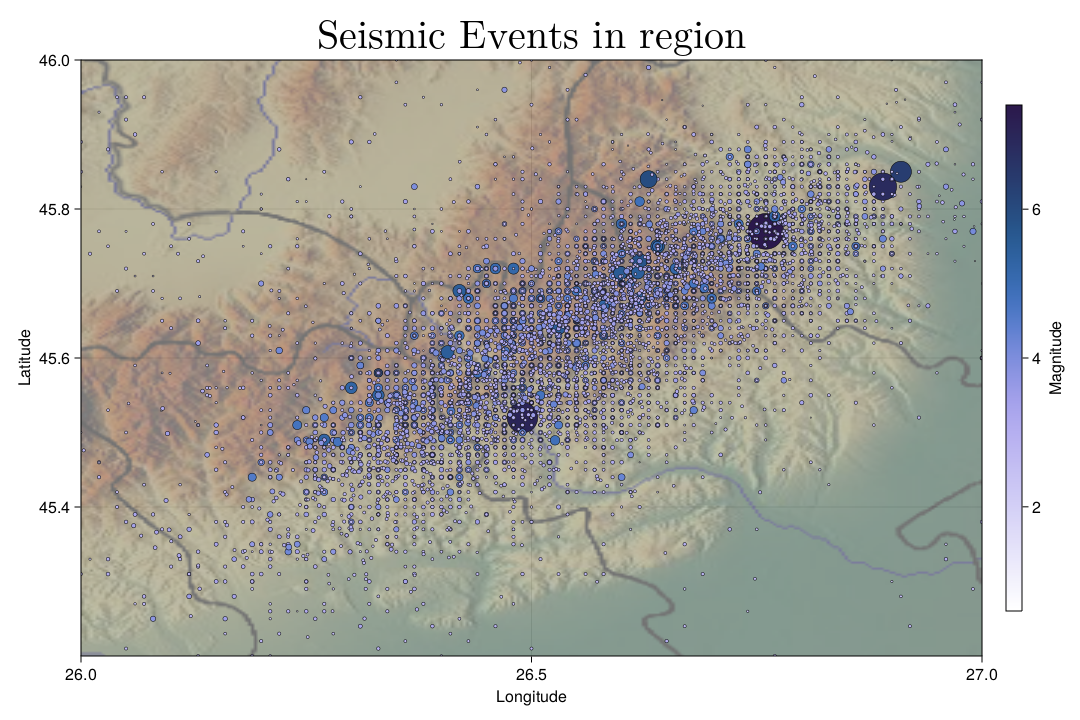

In [ ]:
fig = seismic_scatter_2D(vrancea, trim_year, magnitude_threshold, true, img)
save("./results/$region/vrancea_2D_mag_$magnitude_threshold.png", fig)
fig

In [ ]:
function seismic_scatter_3D_vrancea(region, trim_year, magnitude_threshold, with_image, img=nothing)
	GLMakie.activate!()
	set_theme!(seismic_theme)
	
	mapcoords= Dict("minLat"=>minimum(region.Latitude),
		            "maxLat"=>maximum(region.Latitude),
		            "minLon"=>minimum(region.Longitude),
		            "maxLon"=>maximum(region.Longitude),
		            "minDepth"=>minimum(region.Depth),
		            "maxDepth"=>maximum(region.Depth),
					)
	
	region = region[(region.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(region.Magnitude .> magnitude_threshold),:]

	mapcoords["maxDepth"]=maximum(region.Depth)

	fig = Figure( resolution=(1080, 720))

	ax = Axis3(fig[1,1];    
	    title = L"\text{Seismic Events in region}", titlesize = 40,
	    xlabel = "Longitude", ylabel = "Latitude", zlabel = "Depth",
		# viewmode = :fit,
	    perspectiveness=0.5,
		aspect=(1.3, 1, 2)
	)
	# scale!(ax.scene,1.0,1.0,0.7)
	
	markerSizes = [1.7^x for x in region.Magnitude];
	
	sc = GLMakie.scatter!(ax, region.Longitude, region.Latitude, -region.Depth;
		markersize= markerSizes,
		color= region.Magnitude,
		colormap= (Reverse(:devon), 0.99),
		strokewidth= 0.5,
		shading= false,
	)

	Colorbar(fig[1, 2], sc, label="Magnitude", height=Relative(0.85))
	if with_image == true
		# img_path = "./maps/romania_wikipedia.png"
		# img = load(img_path);
		image!(ax , 
				mapcoords["minLon"] .. mapcoords["maxLon"],
				mapcoords["minLat"] .. mapcoords["maxLat"],

				# range(mapcoords["minLon"],mapcoords["maxLon"],step=0.01),
				# range(mapcoords["minLat"],mapcoords["maxLat"],step=0.01),
			    rotr90(img*0.7); 
			    transformation=(:xy,10)# -mapcoords["maxDepth"]),
				)
	end

    return fig
end

seismic_scatter_3D_vrancea (generic function with 2 methods)

In [ ]:
fig = seismic_scatter_3D_vrancea(vrancea, trim_year, magnitude_threshold, true, img)
save("./results/$region/vrancea_3D_mag_$magnitude_threshold.png", fig)
fig